In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('./Data/combined_injury_records.csv')
df.drop(columns=['injury_category','date_il_retro', 'date_return'], inplace=True)
df

In [ ]:
injury_category_map = {
    'Major Surgery': r'surgery',
    'Muscle strain': r'strain',
    'Ligament sprain': r'sprain',
    'Tendon injury': r'tendon|impingement|tendinopathy',
    'Bone': r'fracture|bone|stress|bone bruise|dislocation',
    'Contusion & Impact': r'contusion|impact',
    'Skin': r'skin|cut|laceration|blister',
    'Illness': r'illness|viral|bacterial|covid|flu',
    'Discomfort & Tightness': r'spasm|tightness|discomfort|fatigue|stiffness|soreness',
    'Neurological': r'concussion|headache|nerve|thoracic outlet',
    'Imflammation': r'itis|inflammation|metatarsalgia',
    'Infection': r'infection|sepsis'
}

In [ ]:
def categorize_injury(injury):
    injury_lower = str(injury).lower()
    for category, pattern in injury_category_map.items():
        if pd.Series(injury_lower).str.contains(pattern, case=False, na=False).any():
            return category
    return 'Other'

df['injury_category'] = df['injury'].apply(categorize_injury) # Categorize injuries by its name


In [ ]:
df = df.loc[df['injury'] != 'TBD']
df = df.loc[df['injury'] != 'Illness'] # Remove rows which injuries are undisclosed or unspecified

In [ ]:
df.boxplot(column='days_injured', by='injury_category', figsize=(12, 6)) # Boxplot of days missed due to injury by injury category
plt.title('Days Injured by Injury Category')
plt.suptitle('')
plt.xlabel('Injury Category')
plt.ylabel('Days Injured')
plt.xticks(rotation=45)
plt.show()

In [ ]:
df.groupby('injury_category')['days_injured'].describe()

In [ ]:
# Divide injuries by body parts

body_part_map = {
    'Joints' : r'shoulder|rotator cuff|scapula|teres major|thoracic|wrist|carpal|ankle|achilles|elbow|tommy john|ucl|ulnar|knee|acl|meniscus|patellar|patella',
    'Lower': r'leg|glute|gluteal|hamstring|quad|calf|shin|adductor|groin|hip|tibial|thigh',
    'Upper': r'chest|pectoral|rib|ribcage|ab|sports hernia|abdominal|oblique|abdomen|core|intercostal|costochondral',
    'Arm': r'arm|biceps|triceps|forearm|flexor',
    'Hand': r'hand|finger|nail|thumb|hamate|pinky',
    'Foot': r'|foot|toe|plantar|heel',
    'Internal': r'kidney|lung|append|col|covid|viral|flu|gastr',
    'Head/Neck' :  r'head|concussion|nasal|nose|facial|face|eye|jaw|neck|cervical',

}

In [ ]:
def extract_body_part(injury):
    injury_lower = str(injury).lower()

    for body_part, sub_text in body_part_map.items():
        if pd.Series(injury_lower).str.contains(sub_text, case=False, na=False).any():
            return body_part
    return 'Other'

df['injured_part'] = df['injury'].apply(extract_body_part)

In [ ]:
# Removing outliers found in the boxplot

q1 = df.groupby(['injury_category', 'injured_part'])['days_injured'].transform(lambda x: x.quantile(0.25))
q3 = df.groupby(['injury_category', 'injured_part'])['days_injured'].transform(lambda x: x.quantile(0.75))

outlier = (q3 - q1) * 1.5

df = df[(df['days_injured'] < (q3 + outlier)) & (df['days_injured'] > (q1 - outlier))]

In [ ]:
def plot_by_injury_category(injury_category):
    df_category = df.loc[df['injury_category'] == injury_category]

    df_category.boxplot(column='days_injured', by='injured_part', figsize=(12, 6))
    plt.title(f'Days Injured by Injury Category ({injury_category})')
    plt.suptitle('')
    plt.xlabel('Injured Part')
    plt.ylabel('Days Injured')
    plt.xticks(rotation=45)
    plt.show()

In [ ]:
plot_by_injury_category('Muscle strain')
plot_by_injury_category('Ligament sprain')
plot_by_injury_category('Tendon injury')
plot_by_injury_category('Bone')
plot_by_injury_category('Contusion & Impact')
plot_by_injury_category('Skin')
plot_by_injury_category('Illness')
plot_by_injury_category('Discomfort & Tightness')
plot_by_injury_category('Neurological')
plot_by_injury_category('Imflammation')
plot_by_injury_category('Infection')

In [ ]:
# Given an injury category, create a boxplot of days missed due to injury for each position

def plot_by_injury_category_pos(injury_category):
    df_category = df.loc[df['injury_category'] == injury_category]

    df_category.boxplot(column='days_injured', by='pos', figsize=(12, 6))
    plt.title(f'Days Injured by Injury Category ({injury_category})')
    plt.suptitle('')
    plt.xlabel('Position')
    plt.ylabel('Days Injured')
    plt.xticks(rotation=45)
    plt.show()

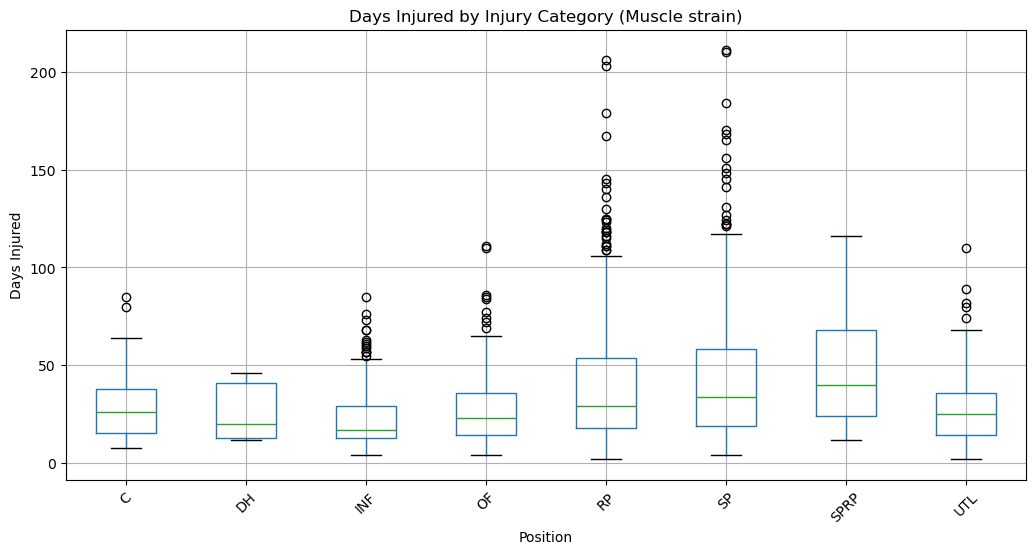

In [922]:
plot_by_injury_category_pos("Muscle strain")


In [ ]:
# Given a injured body part, create a boxplot of days missed due to injury for each injury category

def plot_by_injured_part(injured_part):
    df_category = df.loc[df['injured_part'] == injured_part]

    df_category.boxplot(column='days_injured', by='injury_category', figsize=(12, 6))
    plt.title(f'Days Injured by Injured Part ({injured_part})')
    plt.suptitle('')
    plt.xlabel('Injury Category')
    plt.ylabel('Days Injured')
    plt.xticks(rotation=45)
    plt.show()

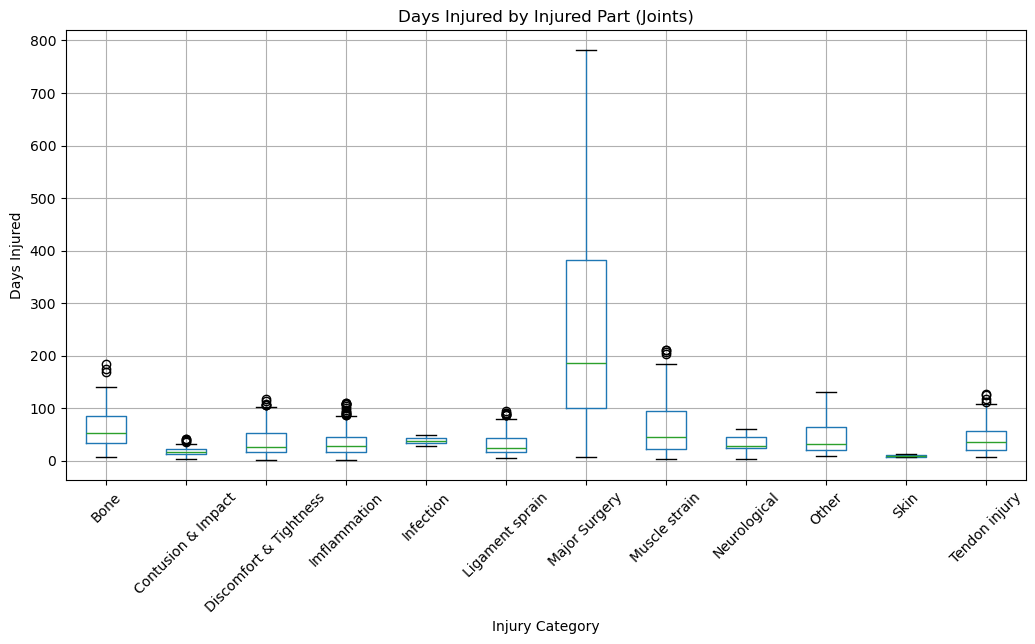

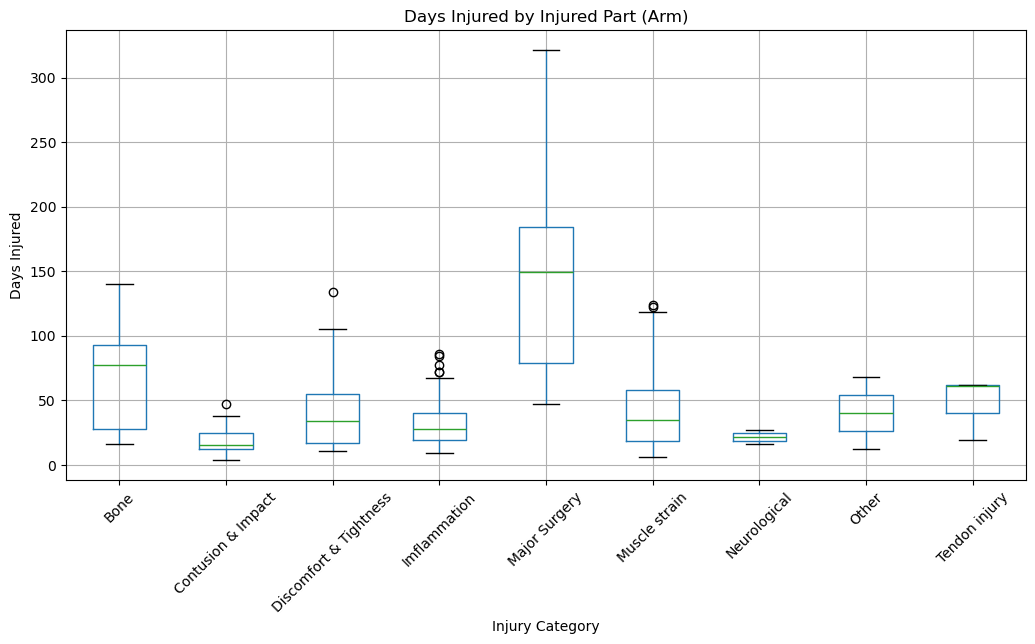

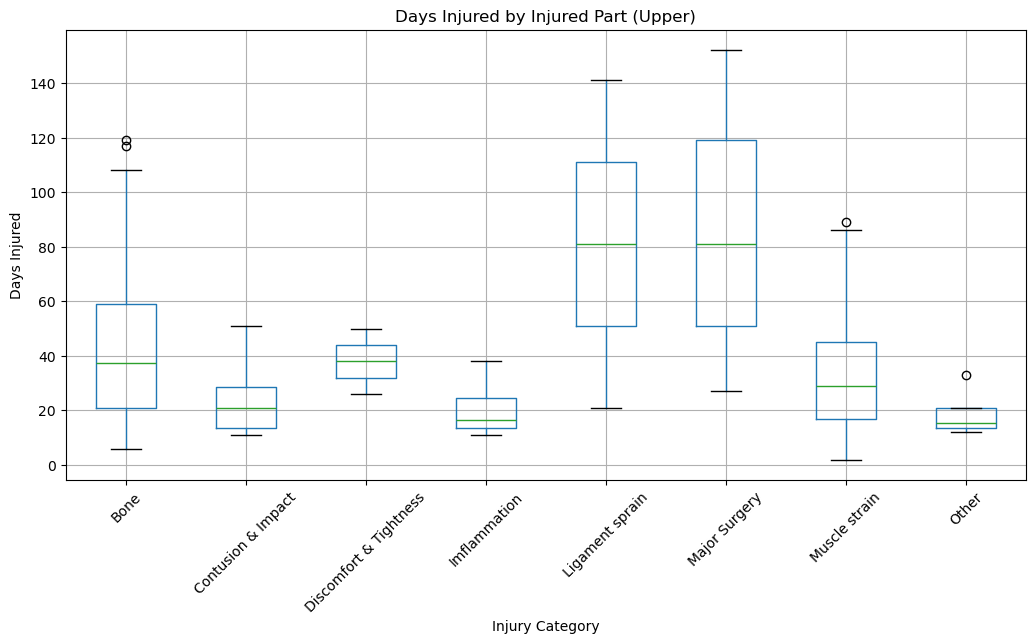

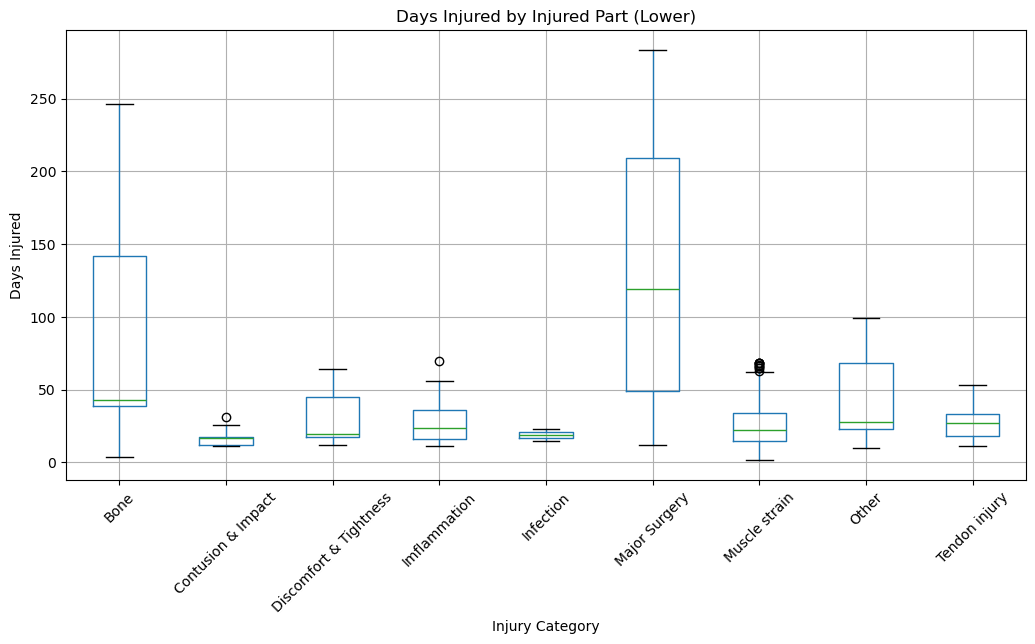

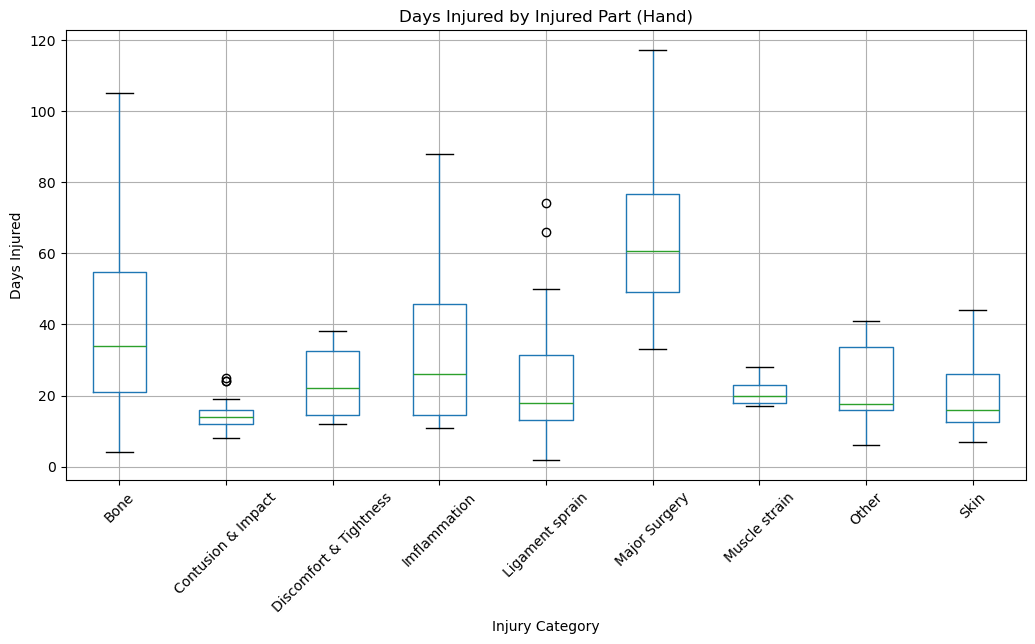

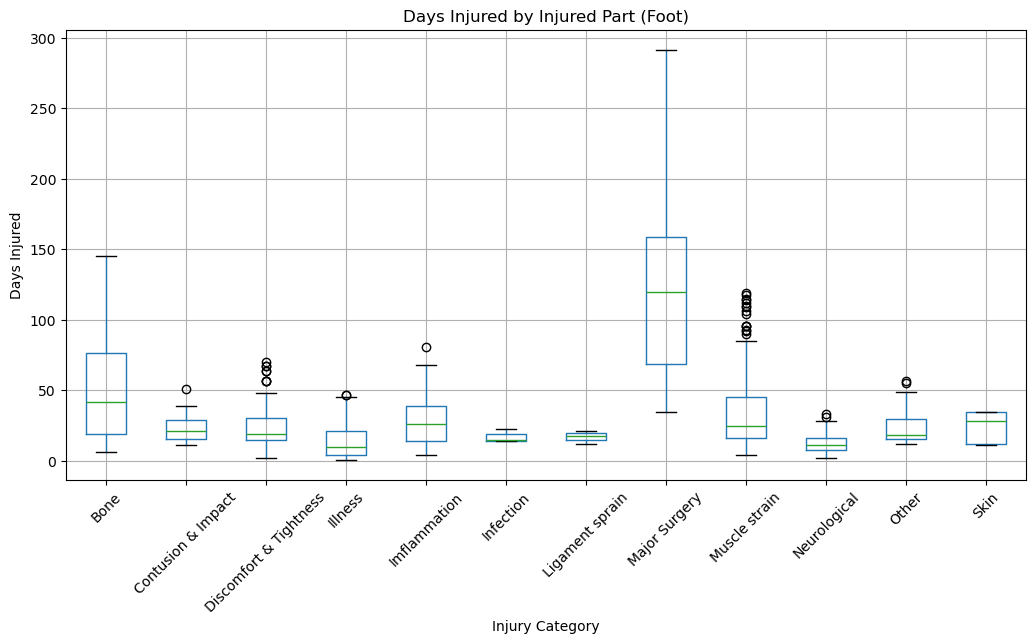

In [924]:
plot_by_injured_part('Joints')
plot_by_injured_part('Arm')
plot_by_injured_part('Upper')
plot_by_injured_part('Lower')
plot_by_injured_part('Hand')
plot_by_injured_part('Foot')


In [ ]:
# Create a severity category for each injury depending on days injured for the classification model.
# If days injured is less than 60 days (upto 2 months) -> mild
# If days injured is less than 120 days (upto 4 months) -> moderate
# If days injured is less than 180 days (upto 6 months) -> severe
# If days injured is greater than 180 days -> season-out

cond_list = [
    (df['days_injured'] <= 60),
    (df['days_injured'] > 60) & (df['days_injured'] <= 120),
    (df['days_injured'] > 120) & (df['days_injured'] <= 180),
    df['days_injured'] > 180
]

choice_list = ['Mild', 'Moderate', 'Severe', 'Season-Out']

df['severity'] = np.select(cond_list, choice_list, default='Mild')
df

In [931]:
def plot_severity_by_category(injury_category):
    df_category = df.loc[df['injury_category'] == injury_category]
    df_category_group = df_category.groupby('injured_part')
    df_category_severity_by_part = df_category_group['severity'].value_counts()
    
    df_category_severity_by_part.plot(kind='bar')
    plt.title(f'Days Injured by Injured Part ({injury_category})')
    plt.suptitle('')
    plt.xlabel('Injury Category')
    plt.ylabel('Severity Count')
    plt.xticks(rotation=90)
    plt.show()

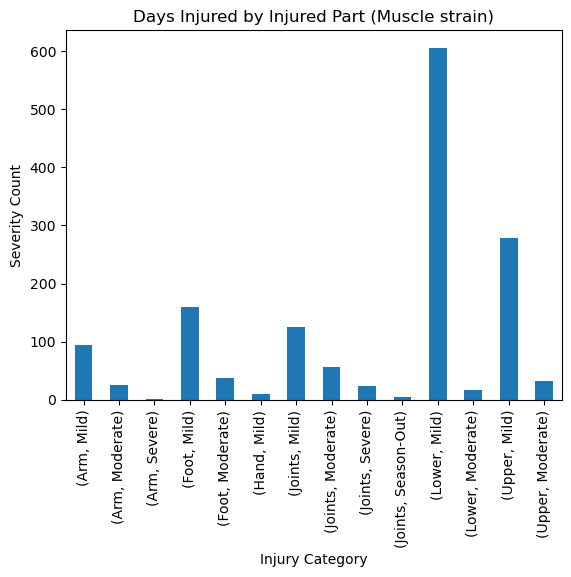

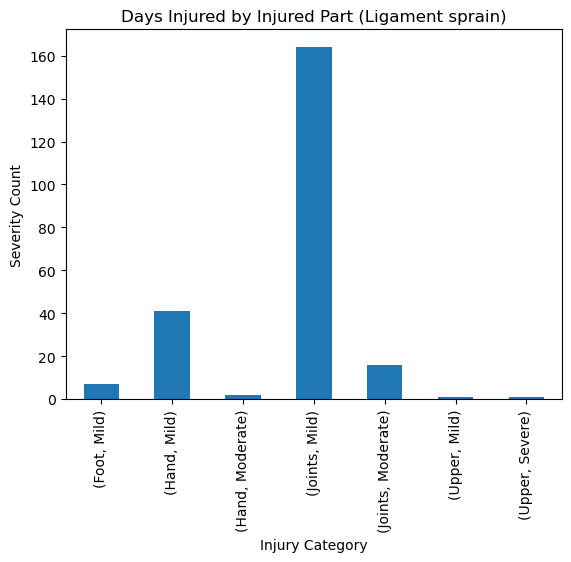

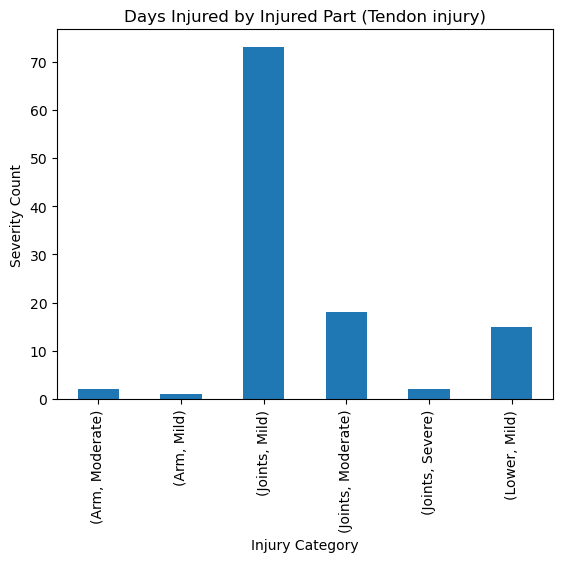

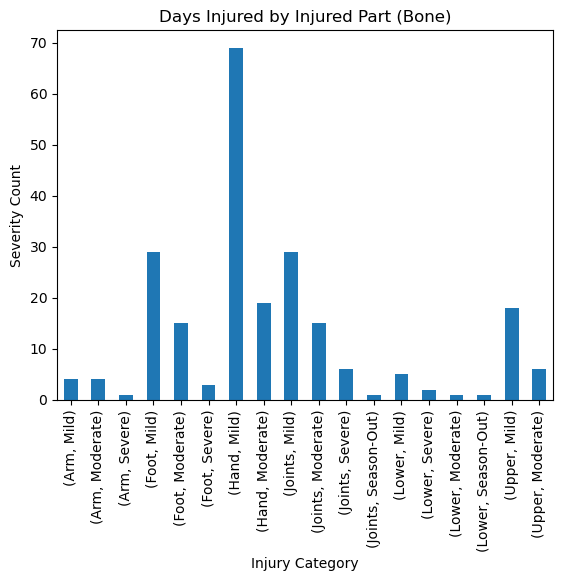

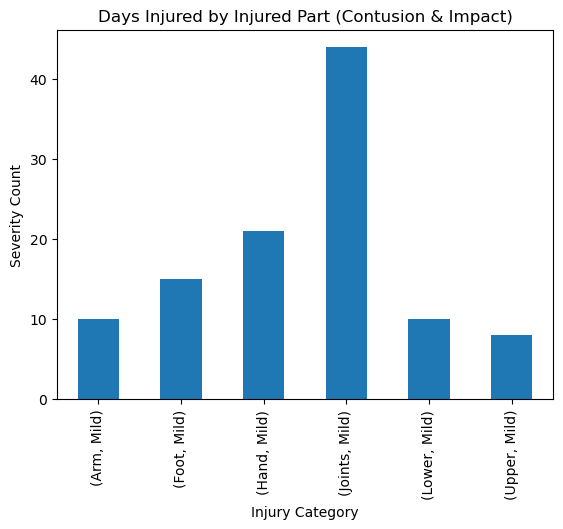

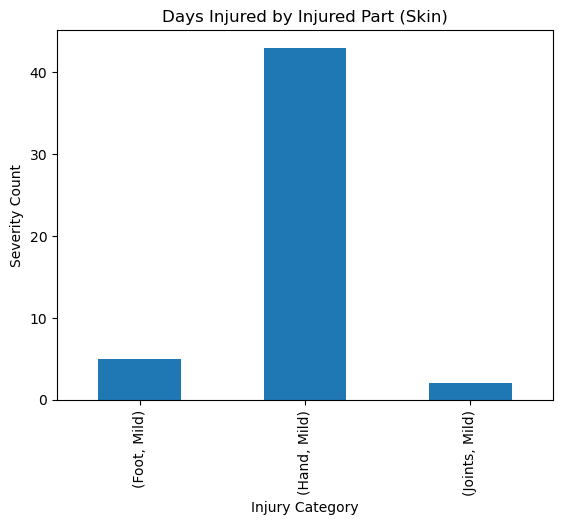

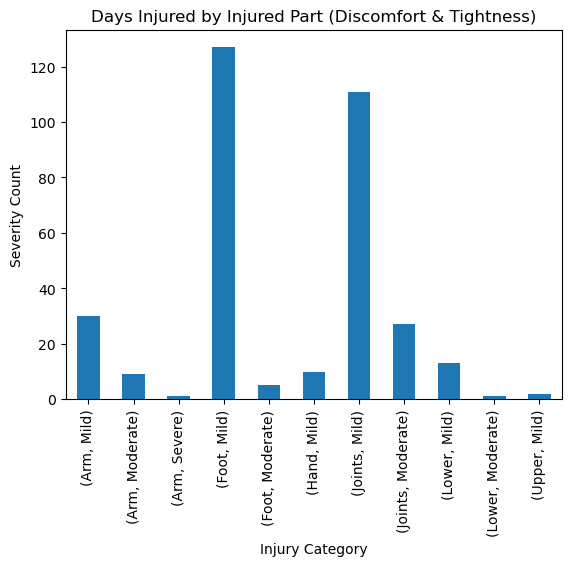

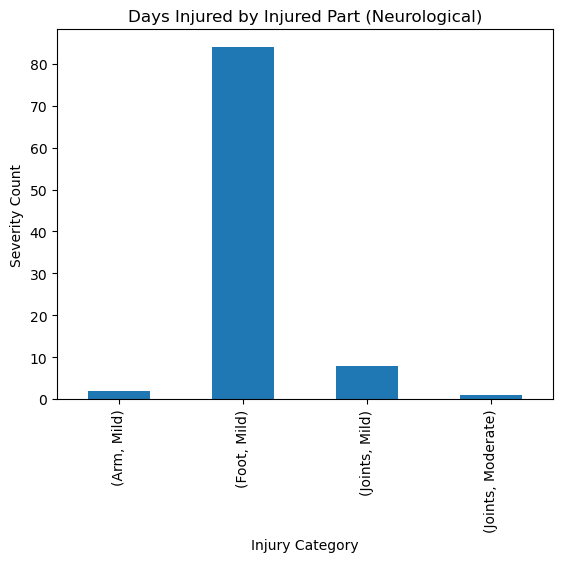

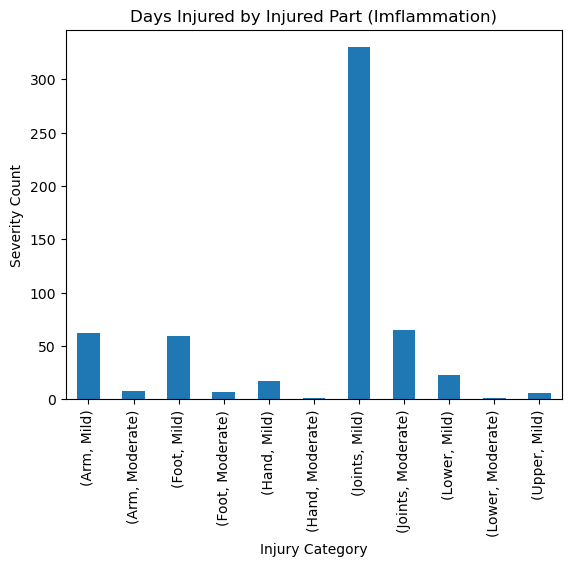

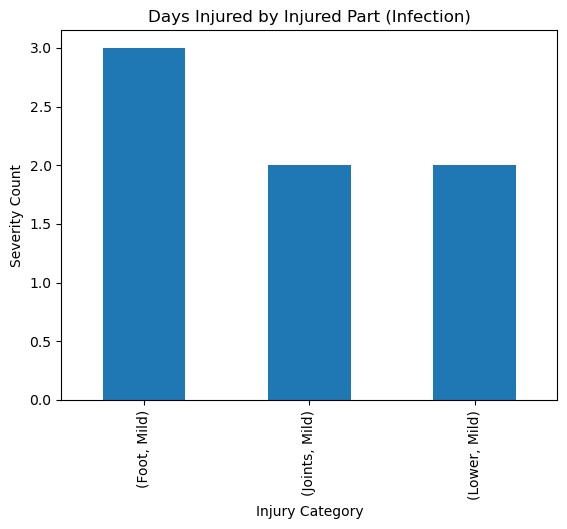

In [932]:
plot_severity_by_category("Muscle strain")
plot_severity_by_category('Ligament sprain')
plot_severity_by_category('Tendon injury')
plot_severity_by_category('Bone')
plot_severity_by_category('Contusion & Impact')
plot_severity_by_category('Skin')
plot_severity_by_category('Discomfort & Tightness')
plot_severity_by_category('Neurological') 
plot_severity_by_category('Imflammation') 
plot_severity_by_category('Infection')   

In [ ]:
# Count the number of injuries with a specific severity category, given an injury category

def severity_counts(injury_category):
    df_category = df[df.injury_category == injury_category]
    test = df_category.loc[:, ['injured_part', 'severity']]
    return test.groupby('injured_part').value_counts()


severity_counts("Major Surgery")

injured_part  severity  
Arm           Moderate        7
              Season-Out      7
              Severe          4
              Mild            2
Foot          Moderate       10
              Severe          7
              Season-Out      4
              Mild            2
Hand          Mild           16
              Moderate       16
Joints        Season-Out    224
              Severe         77
              Moderate       75
              Mild           60
Lower         Season-Out     10
              Mild            8
              Moderate        7
              Severe          3
Upper         Mild            4
              Moderate        4
              Severe          1
Name: count, dtype: int64

In [934]:
chronic_acute_map = {
    'chronic': r'surgery|impingement|tendinopathy|\bstress fracture\b|stress|itis|inflammation|metatarsalgia|spasm|tightness|discomfort|fatigue|stiffness|soreness',
    'acute':  r'strain|sprain|fracture|bone bruise|dislocation|contusion|impact|skin|cut|laceration|blister|illness|viral|bacterial|covid|flu|infection|sepsis'
}

# Given an injury name, categorize the injury by whether it is chronic or acute injury

def categorize_injury(injury):
    injury_lower = str(injury).lower()
    for category, pattern in chronic_acute_map.items():
        if pd.Series(injury_lower).str.contains(pattern, case=False, na=False).any():
            return category
    return 'other'

df['chronic_acute'] = df['injury'].apply(categorize_injury)


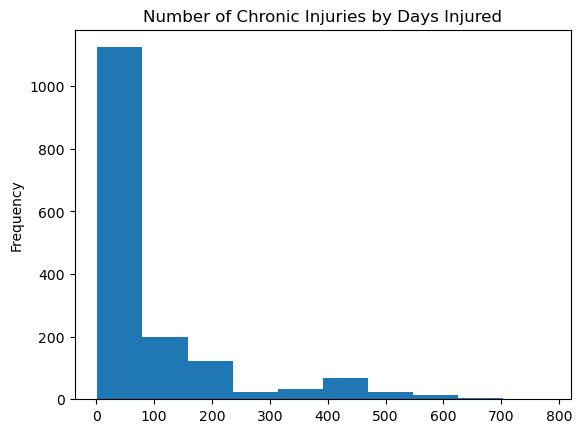

In [937]:
# Create a histogram on chronic injuries by days injured
plt.title('Number of Chronic Injuries by Days Injured')
plt.suptitle('')
plt.xlabel('Days Injured')
plt.ylabel('Frequency')
df.loc[df['chronic_acute'] ==  'chronic']['days_injured'].plot(kind='hist')

plt.show()

Text(0, 0.5, 'Frequency')

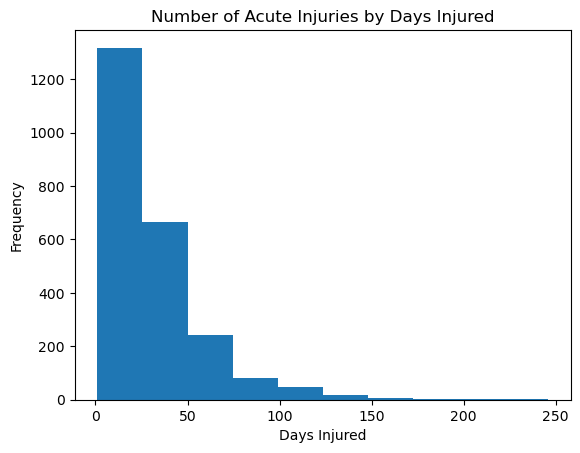

In [ ]:
# Create a histogram on acute injuries by days injured

df.loc[df['chronic_acute'] ==  'acute']['days_injured'].plot(kind='hist')
plt.title('Number of Acute Injuries by Days Injured')
plt.suptitle('')
plt.xlabel('Days Injured')
plt.ylabel('Frequency')

In [ ]:
# Split train and test data by date of injury

df = df.sort_values('date_injury')

# Use the first 80% of rows for training, last 20% for testing
split_index = int(len(df) * 0.8)

train_df = df.iloc[:split_index]
test_df = df.iloc[split_index:]

X_train = train_df[['pos', 'age_at_injury', 'injured_part', 'injury_category', 'chronic_acute']]
y_train = train_df['severity']


X_test = test_df[['pos', 'age_at_injury', 'injured_part', 'injury_category', 'chronic_acute']]
y_test = test_df['severity']

In [ ]:
from catboost import CatBoostClassifier, Pool

model = CatBoostClassifier(
    iterations=10000,
    learning_rate=0.001,
    cat_features=['pos', 'injured_part', 'injury_category', 'chronic_acute'],
)

model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test), # The model looks at this to check its progress
    verbose=1000,
)

In [ ]:
model.score(X_test, y_test)

np.float64(0.7822966507177034)

In [ ]:
model.predict_proba(X_test)